# 12GO - Data Scientist - Test Case 2025

### Test Case 2025: Task
You are provided with a dataset, <code>data.csv</code>, containing over 3 million trip bookings, some of which are labeled as fraudulent.

Objective:
1. Your task is to develop a fraud detection model to predict whether a booking is fraudulent or not. While the dataset is anonymized and partially synthetic, key patterns relevant to fraud detection have been preserved.
2. We do not expect a perfect F1 score, instead, we value your approach, methodology, and the reasoning behind how you achieve the results.

Deliverables:
1. You are free to deliver your results in any format of your choice, link to Git repo, Google Colab, or just Jupyter Notebook (.ipynb). Please ensure the following: (a) Your work is clear and easy to follow. (b) Include a conclusion section summarizing your key findings. This can be part of the notebook, a README file, or a separate presentation — whichever you prefer.

# Exploratory Data Analysis

In [48]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tableone import TableOne
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.api.types import CategoricalDtype

import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial'

os.chdir(r'D:/12GO/src')
data = pd.read_csv('../data/data.csv')

data.sort_values(by = ['bid', 'createdon'], ascending = [True, True], inplace = True)
data.drop_duplicates(inplace = True)

## 1. Data Description

There are 29 variables in the dataset, covering a wide range of aspects relevant to user transactions and fraud detection. The dataset features both numerical and text-based fields, with variables stored as integers (such as <code>bid</code>, <code>insurance_flg</code>, <code>isFraud</code>, and <code>p_attempts</code>), floats (like <code>email_domain_score</code>, <code>email_score</code>, <code>netprice_thb</code>, <code>passenger_passport_score</code>, <code>passenger_score</code>, <code>proxy</code>, <code>recent_abuse</code>, <code>tor</code>, and <code>vpn</code>), and objects that represent text or date information (for instance, <code>channel</code>, <code>createdon</code>, <code>cust_name</code>, <code>date_of_birth</code>, <code>email</code>, <code>godate</code>, <code>ip</code>, <code>nationality</code>, <code>paidon</code>, <code>payer_country</code>, <code>payer_name</code>, <code>role_id</code>, <code>useragent</code>, <code>usr_name</code>, and <code>vehclass_id</code>).

Key variables include <code>bid</code>, a numeric identifier likely used for internal tracking, and <code>channel</code>, which specifies the medium through which the transaction occurred. The <code>createdon</code> field indicates when the transaction record was created, while <code>cust_name</code> and <code>date_of_birth</code> capture personal information about the customer. The <code>email</code> field, together with its associated scores in <code>email_domain_score</code> and <code>email_score</code>, provides insight into the reliability of the provided email address. Additional temporal details are offered through fields such as <code>godate</code> and <code>paidon</code>.

Transaction details and risk factors are further enriched by variables like <code>insurance_flg</code>, which flags the inclusion of insurance, and <code>netprice_thb</code>, which records the transaction amount in Thai Baht. The <code>p_attempts</code> field counts the number of payment attempts, while fraud detection is directly addressed through the <code>isFraud</code> variable. Security-related indicators such as <code>ip</code>, <code>proxy</code>, <code>tor</code>, and <code>vpn</code> help identify potentially suspicious activity, and the <code>recent_abuse</code> variable tracks any recent incidents of problematic behavior.

Other variables provide further context: <code>passenger_passport_score</code> and <code>passenger_score</code> offer risk assessments related to the passenger, whereas <code>payer_country</code> and <code>payer_name</code> denote the payer's details. The dataset also includes <code>role_id</code> to classify the user's role, <code>seats</code> which likely indicates the number of seats booked or involved, and <code>vehclass_id</code> for categorizing vehicle types. Lastly, <code>useragent</code> and <code>usr_name</code> provide further insights into the device and user involved in the transaction.

In [ ]:
data.dtypes

### 1.1 Imbalanced dataset
Fraudulent transactions account for only 0.23% of the dataset—a common imbalance in fraud detection that can render standard metrics like accuracy misleading. For example, a model that always predicts "non-fraud" would achieve high accuracy while missing all fraud cases.

In [51]:
data['isFraud'].value_counts()

0    3456397
1       7825
Name: isFraud, dtype: int64

### 1.2 Negative net prices
The analysis of negative net price records reveals that there are 81 cases, with 80 being non-fraudulent and only 1 flagged as fraud. These records involve 79 unique customers, suggesting that most instances are isolated rather than widespread issues. Additionally, the majority of these bookings involve either 2 seats (43 cases) or 1 seat (31 cases), with only a few cases having 3 or 4 seats. Overall, negative pricing appears to be rare and is predominantly associated with non-fraudulent transactions, possibly reflecting refunds, adjustments, or data entry anomalies rather than intentional fraud.

Since these negative values are not expected and can distort our analysis, it is reasonable to remove them from our dataset.

In [ ]:
data = data[data['netprice_thb'] >= 0]

## 2. Net Price Analysis

### 2.1 Temporal Patterns of Net Price

We want to understand temporal patterns in transaction amounts and how they differ between fraudulent and non-fraudulent activities. In the code below, I converted the transaction creation dates into corresponding month values and mapping these to their month names using Python's calendar module, ensuring that the data is properly categorized by month. To enhance the reliability of our findings, I filtered out extreme outliers in the net price using the interquartile range (IQR) method. Then, I generated boxplots that illustrate the distribution of <code>netprice_thb</code> for each month, further segregated by fraud status. 

This descriptive analysis provides valuable insights into seasonal trends and helps identify periods when fraudulent transactions are more likely to deviate from typical transaction amounts, thereby supporting more targeted fraud detection and prevention strategies for 12GO.

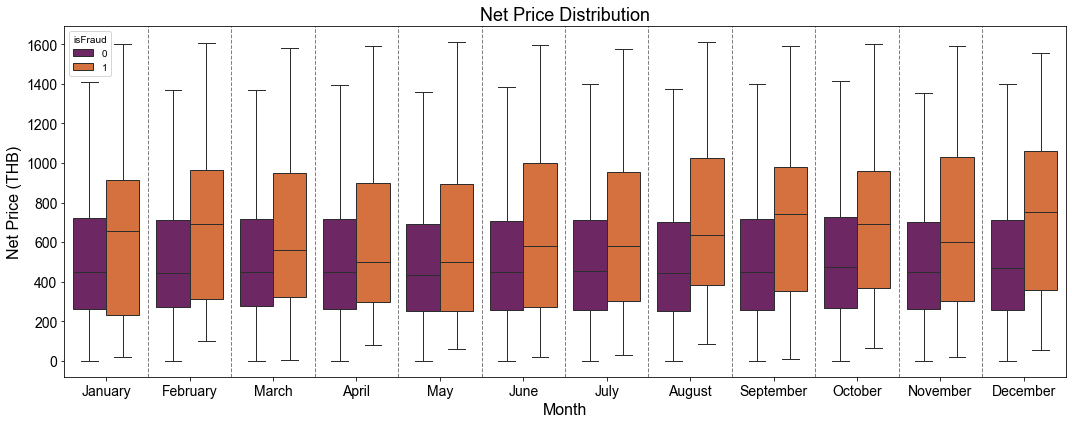

In [ ]:
data['createdon'] = pd.to_datetime(data['createdon'])
data['month'] = data['createdon'].dt.month
Q1 = data['netprice_thb'].quantile(0.25)
Q3 = data['netprice_thb'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[(data['netprice_thb'] >= lower_bound) & (data['netprice_thb'] <= upper_bound)]
filtered_data = filtered_data[filtered_data['netprice_thb'] > 0]
colorblind_palette = sns.color_palette('inferno', n_colors = 2)

month_cat = CategoricalDtype(categories = list(calendar.month_name)[1:], ordered = True)
filtered_data['month_name'] = filtered_data['month'].apply(lambda x: calendar.month_name[x])
filtered_data['month_name'] = filtered_data['month_name'].astype(month_cat)
colorblind_palette = sns.color_palette('inferno', n_colors = 2)

plt.figure(figsize = (15, 6))
ax = sns.boxplot(x = 'month_name', 
                 y = 'netprice_thb', 
                 hue  = 'isFraud', 
                 data = filtered_data, 
                 palette = colorblind_palette, 
                 showfliers = False, 
                 dodge = True, 
                 width = 0.8, 
                 order = list(calendar.month_name)[1:])
months = list(filtered_data['month_name'].cat.categories)

for i in range(len(months) - 1):
    plt.axvline(x=i + 0.5, color='gray', linestyle = '--', linewidth=1)
plt.title('Net Price Distribution', fontsize = 18)
plt.xlabel('Month', fontsize = 16)
plt.ylabel('Net Price (THB)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

From these boxplots, we can observe a consistent difference in net price distributions between fraudulent (orange) and non-fraudulent (purple) transactions. In every category along the x-axis, the **median net price for fraudulent transactions is notably higher than the median for non-fraudulent ones**,  suggesting that fraudulent transactions involve larger net prices compared to genuine ones. Additionally, the overall spread (measured by IQR) of the fraudulent transactions appears to be equal or wider than that of the non-fraudulent group in many of the categories, indicating that fraud-related transactions can vary more widely in value.

The whiskers and outliers in the boxplots also provide insights into the extremes. In several categories, there are very high net price values associated with fraudulent transactions, which may signify that some fraudulent cases involve exceptionally large sums. For the non-fraudulent group, the distribution is comparatively more centered, with fewer extreme outliers. This could reflect more predictable and consistent pricing for genuine transactions. Overall, the consistent gap in medians suggests that net price is a potentially strong discriminator between fraudulent and non-fraudulent activities. Fraudulent transactions not only tend to have higher median values but may also exhibit more variability in net price. 

### 2.2 High Net Price Records vs Vehicle and Seats Distribution


Fraud Status for High Price Records:
0    32780
1     1835
Name: isFraud, dtype: int64


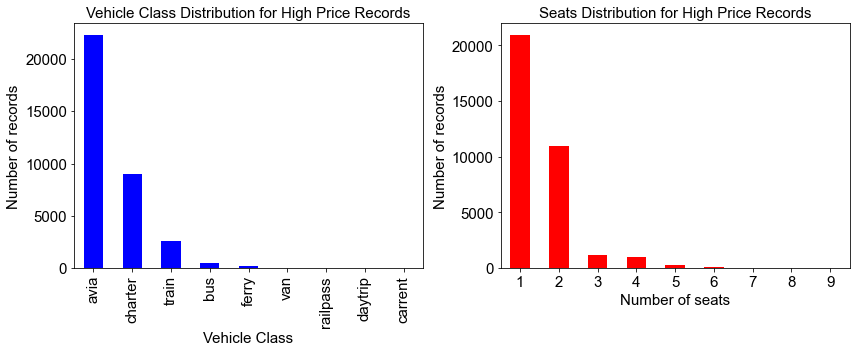

In [ ]:
price_99 = data['netprice_thb'].quantile(0.99)          # THB 4,400 (the 99th percentile)
high_prices = data[data['netprice_thb'] > price_99]     

print("\nFraud Status for High Price Records:")
print(high_prices['isFraud'].value_counts())

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
vehclass_counts = high_prices['vehclass_id'].value_counts()
vehclass_counts.plot(kind = 'bar', ax = axes[0], color = 'blue')
axes[0].set_title('Vehicle Class Distribution for High Price Records', fontsize = 15)
axes[0].set_xlabel('Vehicle Class', fontsize = 15)
axes[0].set_ylabel('Number of records', fontsize=15)
axes[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
axes[0].tick_params(axis = 'x', rotation = 90)

seats_counts = high_prices['seats'].value_counts()
seats_counts.plot(kind = 'bar', ax = axes[1], color = 'red')
axes[1].set_title('Seats Distribution for High Price Records', fontsize = 15)
axes[1].set_xlabel('Number of seats', fontsize = 15)
axes[1].set_ylabel('Number of records', fontsize = 15)
axes[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
axes[1].tick_params(axis = 'x', rotation = 0)

plt.tight_layout()
plt.show()

The analysis of high price records—those *with a net price above THB 4,400 (the 99th percentile)*—reveals 34,615 transactions, representing a very small fraction of the overall dataset. These records are significant because they account for high-value bookings. Notably, 32,780 of these transactions are non-fraudulent, while **1,835 are flagged as fraud**, suggesting that the fraud rate within this high-price segment is relatively elevated compared to the overall dataset.

In addition, these high price records involve 17,191 unique customers, indicating that these transactions are distributed across a diverse user base rather than being concentrated among a few individuals. The vehicle class distribution shows that the majority of these transactions are in the 'avia' category (22,272 records), followed by 'charter' (8,977 records) and 'train' (2,642 records), which may reflect the premium or specialized nature of these services. Moreover, the seats distribution indicates that most of these transactions are for one or two seats (20,925 and 10,944 records, respectively), implying that they typically involve individual or small group travel.

Given these insights, the high price records appear to be legitimate high-value transactions rather than data entry errors or anomalies. Therefore, rather than removing these records, **it is advisable to retain them and consider using appropriate transformations or segmentation strategies during modeling to mitigate their influence while preserving valuable information on premium transactions**.

In [8]:
columns = ['netprice_thb', 'vehclass_id', 'insurance_flg', 'channel']

categorical = ['insurance_flg']
table = TableOne(data, 
                 columns = columns, 
                 groupby = 'isFraud', 
                 pval = True, 
                 missing = False,
                 rename = {'isFraud': 'Fraud Status'},
                 row_percent = False)
table

Grouped by Fraud Status                                          
                                                  Overall                0                1 P-Value
n                                                 3464141          3456317             7824        
netprice_thb, mean (SD)                   741.7 (24743.5)  734.8 (24769.2)  3772.7 (6495.9)  <0.001
vehclass_id, n (%)      avia                 178673 (5.2)     174803 (5.1)      3870 (49.5)  <0.001
                        bus                1345997 (38.9)   1344193 (38.9)      1804 (23.1)        
                        carrent                   1 (0.0)          1 (0.0)                         
                        charter               68739 (2.0)      68645 (2.0)         94 (1.2)        
                        daytrip                   4 (0.0)          4 (0.0)                         
                        ferry              1009561 (29.1)   1008527 (29.2)      1034 (13.2)        
                        insurance              4235 (0.1)       4213 (0.1)         22 (0.3)        
                        railpass                  9 (0.0)          9 (0.0)                         
                        train               637699 (18.4)    636863 (18.4)       836 (10.7)        
                        van                  219223 (6.3)     219059 (6.3)        164 (2.1)        
insurance_flg, n (%)    0                  2655620 (76.7)   2651367 (76.7)      4253 (54.4)  <0.001
                        1                   808521 (23.3)    804950 (23.3)      3571 (45.6)        
channel, n (%)          affiliate           863837 (25.8)    862288 (25.8)      1549 (20.5)  <0.001
                        direct              435364 (13.0)    432962 (13.0)      2402 (31.8)        
                        email                 10505 (0.3)      10419 (0.3)         86 (1.1)        
                        organic             542854 (16.2)    540994 (16.2)      1860 (24.6)        
                        paid               1077467 (32.2)   1076427 (32.2)      1040 (13.8)        
                        partner                  20 (0.0)         20 (0.0)                         
                        referral             152184 (4.5)     151878 (4.5)        306 (4.1)        
                        unknown              263765 (7.9)     263461 (7.9)        304 (4.0)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: vehclass_id, channel.

## 3. Fraud Patterns 

### 3.1 Fraudulent Cases by Hour
The code below calculates the fraud rate and total fraud count by hour of the day, providing insights into the time-based distribution of fraudulent transactions. By grouping the data on an hourly level and converting the fraud rate to a percentage, we can easily identify which hours exhibit higher fraud incidence and plan targeted monitoring or resource allocation accordingly. This information helps highlight temporal risk patterns and supports more informed decision-making in fraud prevention.

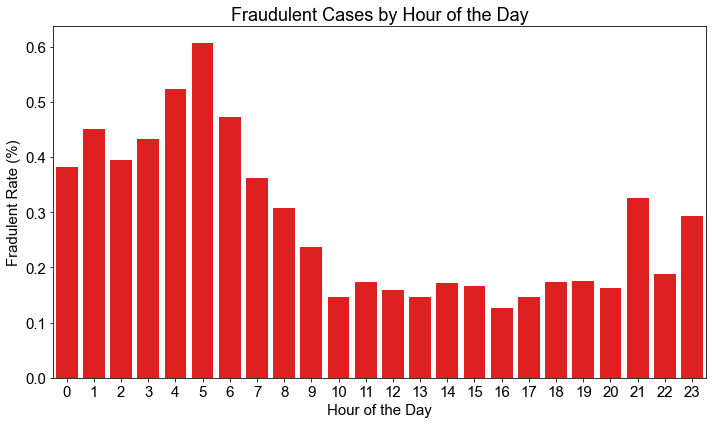

In [ ]:
data['createdon'] = pd.to_datetime(data['createdon'])
data['hour'] = data['createdon'].dt.hour

hourly_summary = (
    data.groupby('hour')['isFraud']
    .agg(fraud_rate = 'mean', fraud_count = 'sum')
    .reset_index())
hourly_summary['fraud_rate'] = hourly_summary['fraud_rate'] * 100
hourly_summary.sort_values(by = 'fraud_rate', ascending = False, inplace = True)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'hour', y = 'fraud_rate', data = hourly_summary, color = 'red')
plt.title('Fraudulent Cases by Hour', fontsize = 18)
plt.xlabel('Hour of the Day',    fontsize = 15)
plt.ylabel('Fradulent Rate (%)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

The analysis shows higher fraud incidents early in the morning. 5 AM has the highest fraud rate (0.61%) with 241 cases, followed by 4 AM (0.52%, 246 cases) and 6 AM (0.47%, 212 cases). 1 AM leads in case count, with 373 cases, while 3 AM has a lower rate (0.43%, 255 cases). These times suggest increased fraud risk and require attention.

### 3.2 Analyzing Fraud Patterns by Vehicle and Insurance

The plot illustrates the fraud rate across different vehicle classes, segmented by insurance status. Using a grouped calculation, we compute the percentage of fraudulent transactions for each combination of vehicle class and insurance flag. The bar plot displays these rates with a blue color for transactions without insurance and red for those with insurance, enabling a clear visual comparison. This visualization helps identify if and how the presence of insurance might be associated with different fraud rates across vehicle classes.

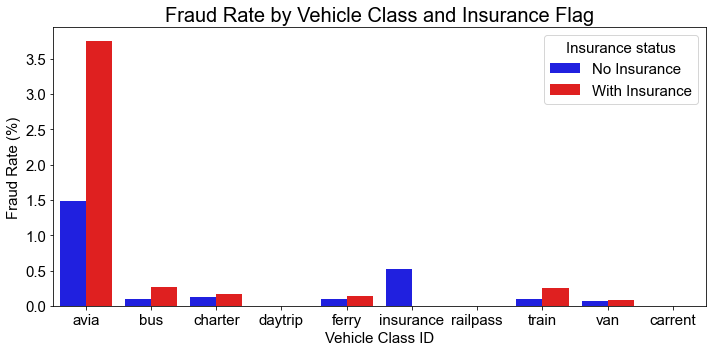

In [ ]:
insurance_vehclass_fraud = data.groupby(['insurance_flg', 'vehclass_id'])['isFraud'].mean().reset_index()
insurance_vehclass_fraud['isFraud'] = insurance_vehclass_fraud['isFraud'] * 100

plt.figure(figsize = (10,5))
custom_palette = {0: 'blue', 1: 'red'}

sns.barplot(
    x = 'vehclass_id',
    y = 'isFraud',
    hue = 'insurance_flg',
    data = insurance_vehclass_fraud,
    hue_order = [0, 1],
    palette = custom_palette
)

plt.title('Fraud Rate by Vehicle Class and Insurance', fontsize = 20)
plt.xlabel('Vehicle Class ID', fontsize = 15)
plt.ylabel('Fraud Rate (%)',   fontsize = 15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['No Insurance' if label == '0' else 'With Insurance' for label in labels]
plt.legend(handles = handles, labels = new_labels, title = 'Insurance status', title_fontsize = 15, fontsize = 15)
plt.tight_layout()
plt.show()

The figure reveals a clear trend: transactions with insurance tend to exhibit higher fraud rates across most vehicle classes. Most especially in aviation bookings, the fraud rate rises from approximately 1.49% without insurance to 3.76% with insurance. Similar patterns are observed in other categories, such as bus, charter, and train bookings. However, some vehicle classes, like daytrip, railpass, and car rent, show no fraud (0%) regardless of the insurance status. This suggests that the **presence of insurance correlates with an increased risk of fraud, particularly in higher-volume segments such as aviation**. As a result, insured transactions in these categories may warrant additional scrutiny to mitigate potential fraud risks. 

Overall, these findings suggest that insurance consistently corresponds to elevated fraud risk, particularly in high-volume segments like aviation, indicating that insured transactions may warrant closer scrutiny.

### 3.3 Analyzing Fraud Patterns by Security Flags
The analysis below calculates, for each security flag, the proportion of fraudulent cases relative to the total cases within that category. For instance, it compares the fraud rate in transactions where 'tor' is flagged (flag 1) versus where it is not flagged (flag 0), and does the same for 'proxy', 'vpn', and 'recent_abuse'. This method highlights how much more likely transactions are to be fraudulent when a particular security flag is present. For 12GO, these insights are critical—they allow the company to target its fraud prevention efforts toward transactions with specific high-risk security flags, optimizing resource allocation and potentially reducing losses from fraudulent activity.

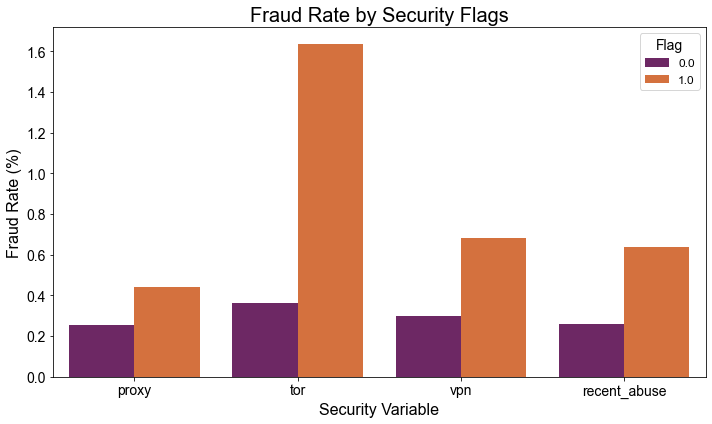

In [ ]:
binary_vars = ['proxy', 'tor', 'vpn', 'recent_abuse']

plot_data = []
for var in binary_vars:
    fraud_rate = data.groupby(var)['isFraud'].mean() * 100
    for idx, val in fraud_rate.items():
        plot_data.append((var, str(idx), val))

df_plot = pd.DataFrame(plot_data, columns=['variable', 'flag', 'fraud_rate'])

plt.figure(figsize = (10, 6))
sns.barplot(x='variable', y = 'fraud_rate', hue = 'flag', data = df_plot, palette = 'inferno')
plt.title('Fraud Rate by Security Flags', fontsize=20)
plt.xlabel('Security Variable', fontsize=16)
plt.ylabel('Fraud Rate (%)', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(title = 'Flag', fontsize = 12, title_fontsize = 14)
plt.tight_layout()
plt.show()

Transactions flagged with suspected fraudulent indicators exhibit significantly higher fraud rates than those without. For example, proxy transactions have a fraud rate of about 0.44%, compared to unflagged indicators (0.25%). The difference is even more pronounced with the 'TOR', where flag 1 transactions show a fraud rate of approximately 1.64%, compared to 0.36% for flag 0. Similarly, for 'vpn' the fraud rate increases from around 0.30% to 0.68%, and for 'recent_abuse' from 0.26% to 0.64% when moving from flag 0 to flag 1. These findings suggest that the presence of these security flags (flag 1) is strongly associated with higher fraudulent activity, highlighting their importance in fraud detection efforts. This suggests that 12GO can focus its fraud prevention and investigation efforts on transactions exhibiting these indicators, such as those with TOR, VPN, proxy, or recent abuse flags. By prioritizing scrutiny on these high-risk transactions, 12GO can better allocate resources, improve fraud detection efficiency, and ultimately reduce financial losses and reputational damage.

This visualization shows the fraud rate for each user acquisition channel by calculating the percentage of fraudulent transactions within each channel. The code groups the dataset by the channel variable, computes the mean of the 'isFraud' indicator (which is then multiplied by 100 to convert it to a percentage), and displays the results in a bar chart. This provides a clear, at-a-glance comparison of how each channel performs in terms of fraud incidence. 

### 3.4 Analyzing Fraud Patterns Across User Acquisition Channels: Fraud Rate vs. Net Price Distribution

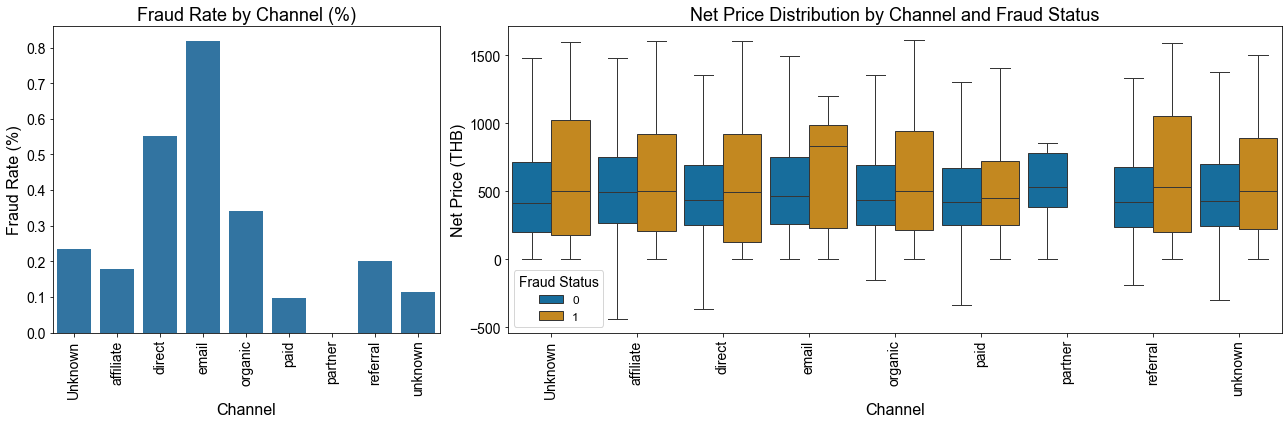

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw = {'width_ratios': [1, 2]})

data['channel'] = data['channel'].astype(str).replace({'nan': 'Unknown', 'NaN': 'Unknown'}).fillna('Unknown')

fraud_by_channel = data.groupby('channel')['isFraud'].mean() * 100
fraud_by_channel = fraud_by_channel.reset_index().rename(columns={'isFraud': 'fraud_rate'})

sns.barplot(x='channel', y='fraud_rate', data=fraud_by_channel, ax=axes[0])
axes[0].set_title('Fraud Rate by Channel (%)', fontsize=18)
axes[0].set_xlabel('Channel', fontsize = 16)
axes[0].set_ylabel('Fraud Rate (%)', fontsize=16)
axes[0].tick_params(axis='x', rotation=90, labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

sorted_channels = sorted(data['channel'].unique())
data['channel'] = pd.Categorical(data['channel'], categories=sorted_channels, ordered=True)

Q1 = data['netprice_thb'].quantile(0.25)
Q3 = data['netprice_thb'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[(data['netprice_thb'] >= lower_bound) & (data['netprice_thb'] <= upper_bound)]
colorblind_palette = sns.color_palette('colorblind', n_colors=len(sorted_channels))

sns.boxplot(x = 'channel', y='netprice_thb', hue='isFraud', data=filtered_data, 
            palette=colorblind_palette, showfliers=False, dodge=True, width=0.9, ax=axes[1])

axes[1].set_title('Net Price Distribution by Channel and Fraud Status', fontsize=18)
axes[1].set_xlabel('Channel', fontsize=16)
axes[1].set_ylabel('Net Price (THB)', fontsize=16)
axes[1].tick_params(axis='x', rotation=90, labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].legend(title='Fraud Status', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


Results reveal notable differences across user acquisition channels such that 'Email' shows the highest fraud rate at about 0.82%, followed by 'direct' (0.55%) and 'organic' (0.34%), while 'paid' and 'partner' channels record the lowest fraud rates. In terms of security indicators, 'partner' and 'unknown' channels exhibit concerning levels — with 'partner' reaching 100% in proxy and recent abuse flags, and 'unknown' showing high rates in proxy (79%), VPN (56%), and recent abuse (62%). The main insight is that channels not only differ in fraud incidence but also in their security profiles, suggesting that transactions from high-risk channels, particularly 'email', 'partner', and 'unknown', warrant closer monitoring and targeted fraud prevention measures.

Therefore, specific user acquisition channels are linked to distinct fraud risks and security profiles. Transactions from the 'email' channel, which exhibit the highest fraud rate, along with those from 'partner' and 'unknown' channels that show alarming levels of security flags, should be subject to enhanced scrutiny. Actions should include implementing targeted monitoring strategies, such as stricter verification processes and real-time risk scoring for these channels, to mitigate potential fraudulent activities and improve overall transaction security.

## 4. Security Profile Patterns

### 4.1 Security by Channels

To assess whether certain channels have a higher concentration of transactions flagged for suspicious activity, I created a heatmap to visualize the average percentage of security types (e.g., proxy, Tor, VPN, and recent abuse) associated with each user acquisition channel. By computing the mean percentage of each security flag per channel, this analysis provides insights into the risk profile of different acquisition sources.

This analysis helps to identify channels that may be more susceptible to fraudulent activity. If certain channels, such as affiliate or direct traffic, show consistently higher proxy, VPN, or Tor usage, it may indicate an increased risk of fraudulent transactions. This insight allows 12GO to enhance fraud detection measures by implementing stricter verification processes for high-risk channels while optimizing fraud prevention strategies based on channel-specific vulnerabilities.

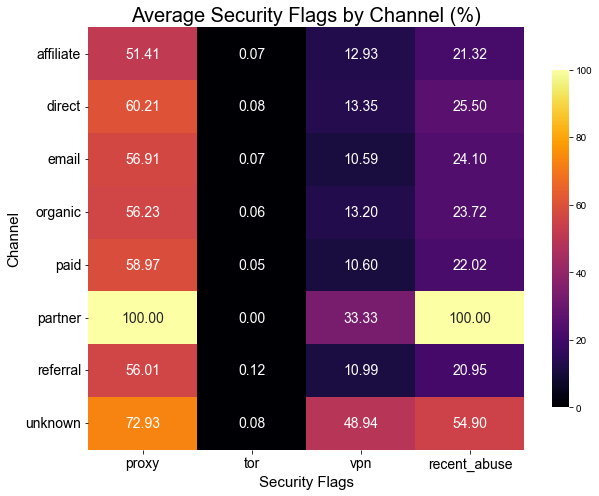

In [116]:
data['channel'] = data['channel'].replace('Unknown', 'unknown')

security_vars = ['proxy', 'tor', 'vpn', 'recent_abuse']
security_summary = data.groupby('channel')[security_vars].mean() * 100

plt.figure(figsize = (9, 7))
sns.heatmap(
    security_summary, 
    annot = True,
    cmap  = 'inferno',
    fmt='.2f',
    annot_kws = {'size': 14},
    cbar_kws  = {'shrink': 0.8}
)
plt.title('Average Security Flags by Channel (%)', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14, rotation = 0)
plt.xlabel('Security Flags', fontsize = 15)
plt.ylabel('Channel', fontsize = 15)
plt.tight_layout()
plt.show()

For most channels—namely affiliate, direct, email, organic, paid, and referral—proxy usage hovers around 51–61%, <code>tor</code> usage remains very low at about 0.05–0.12%, and <code>vpn</code> flags typically range from 10–13%. By contrast, <code>partner</code> and <code>unknown</code> channels show markedly higher levels of suspicious activity. The <code>partner</code> stands out with 100% of transactions flagged for recent abuse, coupled with elevated proxy and VPN usage (33.33% for VPN). Similarly, the <code>unknown</code> channel displays proxy usage at 72.93%, a VPN rate of 56.05%, and a 61.54% recent abuse flag. These indicators suggest that both <code>partner</code> and <code>unknown</code> may present significantly higher security risks, warranting more robust monitoring and fraud prevention measures.

### 4.2 Fraud Risk Assessment by Acquisition Channel
The following table provides a comprehensive evaluation of fraud risk across different user acquisition channels by combining fraud rate with key security flags (<code>proxy</code>, <code>Tor</code>, <code>vpn</code>, and <code>recent_abuse</code>). 

A high fraud rate in a channel, coupled with elevated security flags, suggests a greater likelihood of fraudulent activity. For example, if a channel has a high percentage of transactions using proxies or VPNs, it may indicate users attempting to hide their identities, increasing the risk of fraud. Conversely, channels with low fraud rates and minimal security flag usage suggest a lower likelihood of fraudulent behavior. By leveraging these insights, 12GO can allocate fraud prevention resources more effectively, tightening security for high-risk channels while maintaining a seamless experience for legitimate users.

In [105]:
channels = data['channel'].unique()

fraud_by_channel = data.groupby('channel')['isFraud'].mean() * 100  # fraud rate in %
security_vars = ['proxy', 'tor', 'vpn', 'recent_abuse']
security_summary = data.groupby('channel')[security_vars].mean() * 100

channel_summary = pd.concat([fraud_by_channel, security_summary], axis=1)
channel_summary = channel_summary.reset_index()
channel_summary.columns = ['Channel', 'Fraud Rate (%)', 'Proxy (%)', 'TOR (%)', 'VPN (%)', 'Recent Abuse (%)']
channel_summary

,Channel,Fraud Rate (%),Proxy (%),TOR (%),VPN (%),Recent Abuse (%)
0,affiliate,0.179310,51.407718,0.067935,12.929185,21.319430
1,direct,0.551706,60.211654,0.078185,13.346094,25.504890
2,email,0.818658,56.914326,0.071098,10.593672,24.102382
3,organic,0.342629,56.225988,0.059996,13.201367,23.715581
4,paid,0.096521,58.969578,0.046973,10.598564,22.024498
5,partner,0.000000,100.000000,0.000000,33.333333,100.000000
6,referral,0.201722,56.007597,0.122184,10.989330,20.954005
7,unknown,0.152127,72.931649,0.082293,48.944705,54.897611


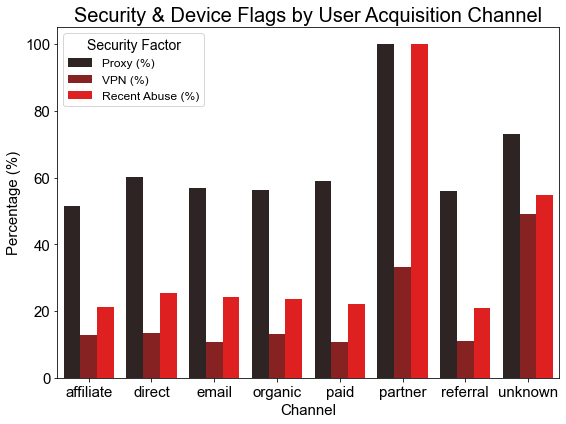

In [112]:
channel_summary_melt = channel_summary.melt(id_vars = ['Channel', 'Fraud Rate (%)'], 
                                            value_vars = ['Proxy (%)', 'TOR (%)', 'VPN (%)', 'Recent Abuse (%)'], 
                                            var_name   = 'Security Factor', 
                                            value_name = 'Percentage')
channel_summary_melt = channel_summary_melt[channel_summary_melt['Security Factor'] != 'TOR (%)']
plt.figure(figsize = (8,6))
sns.barplot(x = 'Channel', 
            y = 'Percentage', 
            hue = 'Security Factor', 
            data = channel_summary_melt, 
            color = 'red')

plt.title('Security & Device Flags by User Acquisition Channel', fontsize=20)
plt.xlabel('Channel', fontsize = 15)
plt.ylabel('Percentage (%)', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Security Factor', fontsize = 12, title_fontsize = 14)
plt.tight_layout()
plt.show()

Fraud rates across different user acquisition channels, combined with security flags (proxy, VPN, and recent abuse), reveals key insights into potential fraud risk factors for 12GO. Channels such as email (0.82%), direct (0.55%), and organic search (0.34%) exhibit relatively higher fraud rates, whereas paid marketing (0.09%) and affiliate traffic (0.18%) show lower fraud risk. The unknown category, which likely represents unclassified or misattributed traffic, also has a lower fraud rate (0.15%), but it exhibits significantly high security flag percentages, indicating potential risk.

From a security standpoint, proxy usage is highest in partner (100%) and direct (60%) channels, followed by email (56.9%) and organic (56.2%). **Proxy usage is often associated with users attempting to conceal their identities, which can be an indicator of fraudulent activity.** Similarly, **VPN usage is highest in the unknown category (48.9%), followed by partner (33.3%), direct (13.3%), and organic (13.2%), suggesting that these channels might attract users who prefer to mask their locations.** The recent abuse flag, which indicates prior suspicious or abusive activity, is highest in partner (100%) and unknown (54.9%), highlighting potential vulnerabilities in these channels. 

The partner channel stands out with extreme security flag values (100% for proxy and recent abuse), yet it reports a 0% fraud rate—this inconsistency suggests either **an anomaly in fraud detection or that transactions within this channel undergo strict internal verification**, reducing actual fraud occurrences. Conversely, direct traffic, which has one of the highest fraud rates (0.55%), also has elevated security flags across all metrics, reinforcing the need for additional fraud monitoring and verification for transactions acquired through direct visits.

## 5. Univariate Analysis: Logistic Regression

A univariate feature selection was performed to identify the most relevant predictors for fraud detection. By individually assessing each feature’s relationship with the target variable (<code>isFraud</code>), we aimed to filter out irrelevant or weakly correlated variables before proceeding with more complex modeling. The approach used logistic regression with L1 regularization to quantify the impact of each feature, alongside odds ratio interpretation and Variance Inflation Factor (VIF) analysis to assess feature redundancy.

In [31]:
binary_cols = ['insurance_flg', 'proxy', 'tor', 'vpn', 'recent_abuse']
for col in binary_cols:
    data[col] = data[col].fillna(0).astype(int)

date_cols = ['createdon', 'paidon', 'godate', 'date_of_birth']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

cat_cols = ['channel', 'vehclass_id', 'role_id', 'payer_country', 'nationality']
le = LabelEncoder()
for col in cat_cols:
    data[col] = data[col].astype(str)
    data[col] = le.fit_transform(data[col])

penalty_choice = 'l1'
features = data.columns.drop('isFraud')
results = []
for feature in features:
    X_feature = pd.to_numeric(data[feature], errors='coerce')
    y = data['isFraud']
    mask = X_feature.notnull()
    X_feature = X_feature[mask].values.reshape(-1, 1)
    y_sub = y[mask].values
    try:
        model = LogisticRegression(class_weight = 'balanced',
                                   penalty = penalty_choice, 
                                   solver  = 'liblinear', 
                                   random_state = 42).fit(X_feature, y_sub)
        coef = model.coef_[0][0]
        odds_ratio = np.exp(coef)
        results.append([feature, coef, odds_ratio])
    except Exception:
        continue
results_df = pd.DataFrame(results, columns = ['feature', 'coef', 'odds_ratio'])

X_all = data[features].copy()
X_all = X_all.apply(pd.to_numeric, errors = 'coerce')
X_all = X_all.dropna(axis = 1, how = 'any')
vif_list = []
for i in range(X_all.shape[1]):
    vif_value = variance_inflation_factor(X_all.values, i)
    vif_list.append(vif_value)
vif_df = pd.DataFrame({'feature': X_all.columns, 'VIF': vif_list})

final_results = results_df.merge(vif_df, on = 'feature', how = 'left')
final_results

,feature,coef,odds_ratio,VIF
0,bid,5.475100e-10,1.000000,0.996705
1,channel,-1.165037e-01,0.890027,1.010758
2,createdon,0.000000e+00,1.000000,40.922832
3,date_of_birth,0.000000e+00,1.000000,1.000064
4,email_domain_score,1.774987e-01,1.194227,1.000008
5,email_score,1.609485e-01,1.174624,1.001816
6,godate,0.000000e+00,1.000000,32494.093002
7,insurance_flg,1.017024e+00,2.764953,1.001137
8,nationality,2.865305e-04,1.000287,0.998741
9,netprice_thb,4.098258e-05,1.000041,1.000946


The univariate logistic regression results indicate that several features have a strong association with fraud while maintaining low multicollinearity, as reflected by their variance inflation factor (VIF) close to 1. For example, the insurance flag (odds ratio ≈2.76) and payment attempts (odds ratio ≈1.48) are robust predictors — suggesting that **transactions with purchased insurance or multiple payment attempts are considerably more likely to be fraudulent**. Among the security and device indicators, the **use of proxies** (odds ratio ≈3.29), **TOR** (odds ratio ≈6.97), **VPNs** (odds ratio ≈3.76), and a **recent abuse flag** (odds ratio ≈4.00) strongly increase fraud odds. Meanwhile, email risk scores also show meaningful effects (odds ratios ≈1.19 and ≈1.18), confirming that **higher email-associated risk is linked to fraud**. 

In contrast, the time-related variables (createdon, godate, paidon) exhibit extremely high VIFs (ranging from about 41 to over 32,000), indicating severe multicollinearity and suggesting that these variables are redundant for predictive purposes. Similarly, the booking ID (bid) shows no predictive effect. 

Based on these results and their real-world relevance — where **increased security risk signals, high payment attempts, and the presence of insurance stand out as clear markers of fraudulent activity** — we recommend including the following features in your machine learning model: email_domain_score, email_score, insurance_flg, p_attempts, proxy, recent_abuse, tor, vpn, seats, vehclass_id, passenger_passport_score, passenger_score, payer_country, role_id, channel, nationality, and netprice_thb. These variables not only demonstrate statistically significant associations with fraud but also represent actionable insights, such as targeting transactions with high security risks or multiple payment attempts for further investigation.